## 1. Imports

In [53]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from catboost import CatBoostClassifier

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print("✅ Imports loaded")

✅ Imports loaded


## 2. Feature Engineering

Generate trading features matching the Golden Trio notebook:
- **ETH** (Target Asset): Returns, Volatility, RSI, ADX, VWAP
- **BTC** (Beta Asset): Returns, Volatility, Price-to-MA ratios
- **Market Index** (15 Assets): Equal-weighted returns and volatility

In [54]:
class FeatureEngine:
    """Generate trading features matching the Golden Trio notebook"""
    
    @staticmethod
    def compute_rsi(series, period=14):
        """Compute RSI indicator"""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

print("✅ RSI method defined")

✅ RSI method defined


In [55]:
    @staticmethod
    def compute_adx(high, low, close, period=14):
        """Compute ADX (Average Directional Index) indicator"""
        # True Range
        tr1 = high - low
        tr2 = abs(high - close.shift(1))
        tr3 = abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        
        # Directional Movement
        up_move = high - high.shift(1)
        down_move = low.shift(1) - low
        
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0)
        
        # Smoothed indicators
        atr = tr.rolling(window=period).mean()
        plus_di = 100 * pd.Series(plus_dm).rolling(window=period).mean() / atr
        minus_di = 100 * pd.Series(minus_dm).rolling(window=period).mean() / atr
        
        # ADX
        dx = 100 * abs(plus_di - minus_di) / (plus_di + minus_di)
        adx = dx.rolling(window=period).mean()
        
        return adx

FeatureEngine.compute_adx = compute_adx
print("✅ ADX method added")

✅ ADX method added


In [56]:
    @staticmethod
    def compute_vwap(df):
        """Compute VWAP (Volume Weighted Average Price)"""
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
        return vwap

FeatureEngine.compute_vwap = compute_vwap
print("✅ VWAP method added")

✅ VWAP method added


In [57]:
    @staticmethod
    def build_asset_features(df, asset_name, lookbacks=[5, 10, 30]):
        """Build features for a single asset"""
        features = {}
        
        price_col = f'{asset_name}_price'
        vol_col = f'{asset_name}_volume'
        
        if price_col not in df.columns or vol_col not in df.columns:
            return {}
        
        price = df[price_col]
        volume = df[vol_col]
        
        # Returns
        features[f'{asset_name}_return'] = price.pct_change()
        features[f'{asset_name}_log_return'] = np.log(price / price.shift(1))
        
        # Volatility
        for window in lookbacks:
            features[f'{asset_name}_volatility_{window}'] = \
                features[f'{asset_name}_return'].rolling(window).std()
        
        # Volume features
        features[f'{asset_name}_volume_change'] = volume.pct_change()
        for window in lookbacks:
            features[f'{asset_name}_volume_ma_{window}'] = \
                volume.rolling(window).mean()
        
        # RSI
        features[f'{asset_name}_rsi'] = FeatureEngine.compute_rsi(price, 14)
        
        # Price moving averages
        for window in lookbacks:
            ma = price.rolling(window).mean()
            features[f'{asset_name}_ma_{window}'] = ma
            features[f'{asset_name}_price_to_ma_{window}'] = price / ma - 1
        
        return pd.DataFrame(features)

FeatureEngine.build_asset_features = build_asset_features
print("✅ Asset features method added")

✅ Asset features method added


In [58]:
    @staticmethod
    def build_market_features(df, assets):
        """Build market-wide features from multiple assets"""
        features = {}
        
        # Calculate equal-weighted market index
        prices = []
        for asset in assets:
            price_col = f'{asset}_price'
            if price_col in df.columns:
                prices.append(df[price_col])
        
        if len(prices) > 0:
            market_price = pd.concat(prices, axis=1).mean(axis=1)
            
            # Market returns
            features['market_return'] = market_price.pct_change()
            features['market_log_return'] = np.log(market_price / market_price.shift(1))
            
            # Market volatility
            features['market_volatility_5'] = features['market_return'].rolling(5).std()
            features['market_volatility_10'] = features['market_return'].rolling(10).std()
        
        return pd.DataFrame(features)

FeatureEngine.build_market_features = build_market_features
print("✅ FeatureEngine fully assembled!")

✅ FeatureEngine fully assembled!


## 3. Committee Scorer

Implements the weighted voting system:

| Committee Member | Weight | Condition |
|-----------------|--------|------------|
| 🎩 **The Chairman** (ML Model) | 2 pts | Probability > 0.60 |
| 📈 **The Trend** (ADX) | 1 pt | ADX > 20 |
| 💰 **The Value** (VWAP) | 1 pt | Close > VWAP |
| 🚀 **The Momentum** (RSI) | 1 pt | 50 < RSI < 75 |
| 👥 **The Crowd** (L2 Imbalance) | 1 pt | Bid Vol > 1.5× Ask Vol |

**Entry Threshold**: ≥ 4 points

In [59]:
class CommitteeScorer:
    """Committee-based signal generation system"""
    
    def __init__(self, model_path):
        """Initialize with CatBoost model"""
        self.model = CatBoostClassifier()
        self.model.load_model(model_path)
        print(f"✅ Model loaded from {model_path}")

print("✅ CommitteeScorer initialization defined")

✅ CommitteeScorer initialization defined


In [60]:
    def calculate_score(self, row, model_features, l2_available=False):
        """
        Calculate committee score (0-6 points)
        Need >= 4 points to trade
        """
        score = 0
        reasons = []
        
        # 1. The Chairman (ML Model) - Worth 2 points
        try:
            feature_vector = row[model_features].values.reshape(1, -1)
            prob = self.model.predict_proba(feature_vector)[0][1]  # Probability of UP
            
            if prob > 0.60:
                score += 2
                reasons.append(f"ML_Model({prob:.3f})")
        except Exception as e:
            pass  # Skip if features missing
        
        # 2. The Trend (ADX) - Worth 1 point
        if 'ETH_adx' in row.index and not pd.isna(row['ETH_adx']):
            if row['ETH_adx'] > 20:
                score += 1
                reasons.append(f"ADX({row['ETH_adx']:.1f})")
        
        # 3. The Value (VWAP) - Worth 1 point
        if 'ETH_vwap' in row.index and 'ETH_close' in row.index:
            if not pd.isna(row['ETH_vwap']) and not pd.isna(row['ETH_close']):
                if row['ETH_close'] > row['ETH_vwap']:
                    score += 1
                    reasons.append(f"VWAP")
        
        # 4. The Momentum (RSI) - Worth 1 point
        if 'ETH_rsi' in row.index and not pd.isna(row['ETH_rsi']):
            if 50 < row['ETH_rsi'] < 75:
                score += 1
                reasons.append(f"RSI({row['ETH_rsi']:.1f})")
        
        # 5. The Crowd (L2 Data) - Worth 1 point (optional)
        if l2_available:
            if 'bid_vol' in row.index and 'ask_vol' in row.index:
                if not pd.isna(row['bid_vol']) and not pd.isna(row['ask_vol']):
                    if row['ask_vol'] > 0 and row['bid_vol'] > 1.5 * row['ask_vol']:
                        score += 1
                        reasons.append(f"L2_Imbalance")
        
        return score, reasons

CommitteeScorer.calculate_score = calculate_score
print("✅ CommitteeScorer fully assembled!")

✅ CommitteeScorer fully assembled!


## 4. Trade Class

Represents a single trade with:
- Entry/Exit tracking
- Take Profit (+1.5%) / Stop Loss (-1.0%)
- Fee calculation (0.08% per side)

In [61]:
class Trade:
    """Represents a single trade"""
    
    def __init__(self, entry_time, entry_price, direction='long', size=1.0, 
                 tp_pct=0.015, sl_pct=0.01, fee_pct=0.0008):
        self.entry_time = entry_time
        self.entry_price = entry_price
        self.direction = direction
        self.size = size
        self.fee_pct = fee_pct
        
        # Risk management levels
        self.tp_price = entry_price * (1 + tp_pct)
        self.sl_price = entry_price * (1 - sl_pct)
        
        # Entry cost
        self.entry_cost = entry_price * size * (1 + fee_pct)
        
        # Trade state
        self.exit_time = None
        self.exit_price = None
        self.exit_reason = None
        self.pnl = None
        self.return_pct = None

print("✅ Trade initialization defined")

✅ Trade initialization defined


In [62]:
    def check_exit(self, current_time, current_price):
        """Check if trade should exit based on TP/SL"""
        if self.exit_time is not None:
            return False  # Already exited
        
        # Check Take Profit
        if current_price >= self.tp_price:
            self.exit(current_time, current_price, 'TP')
            return True
        
        # Check Stop Loss
        if current_price <= self.sl_price:
            self.exit(current_time, current_price, 'SL')
            return True
        
        return False

Trade.check_exit = check_exit
print("✅ TP/SL check method added")

✅ TP/SL check method added


In [63]:
    def exit(self, exit_time, exit_price, reason):
        """Execute trade exit"""
        self.exit_time = exit_time
        self.exit_price = exit_price
        self.exit_reason = reason
        
        # Calculate PnL including fees
        exit_value = exit_price * self.size * (1 - self.fee_pct)
        self.pnl = exit_value - self.entry_cost
        self.return_pct = (self.pnl / self.entry_cost) * 100
    
    def to_dict(self):
        """Convert trade to dictionary"""
        return {
            'entry_time': self.entry_time,
            'entry_price': self.entry_price,
            'exit_time': self.exit_time,
            'exit_price': self.exit_price,
            'exit_reason': self.exit_reason,
            'pnl': self.pnl,
            'return_pct': self.return_pct,
            'duration': (self.exit_time - self.entry_time) if self.exit_time else None
        }

Trade.exit = exit
Trade.to_dict = to_dict
print("✅ Trade class fully assembled!")

✅ Trade class fully assembled!


## 5. Backtest Engine - Part 1: Initialization

In [64]:
class BacktestEngine:
    """Main backtesting engine"""
    
    def __init__(self, data_5s_path, model_path, initial_capital=10000):
        """Initialize backtesting engine"""
        self.initial_capital = initial_capital
        self.capital = initial_capital
        
        # Load data
        print("📂 Loading 5-second market data...")
        self.data_5s = pd.read_csv(data_5s_path)
        self.data_5s['timestamp'] = pd.to_datetime(self.data_5s['timestamp'], format='ISO8601')
        self.data_5s = self.data_5s.sort_values('timestamp').reset_index(drop=True)
        print(f"   ✅ Loaded {len(self.data_5s):,} rows")
        
        # Resample to 1-minute for feature generation
        print("🔄 Resampling to 1-minute OHLCV...")
        self.data_1m = self._resample_to_1min()
        print(f"   ✅ Created {len(self.data_1m):,} 1-minute bars")
        
        # Generate features on 1-minute data
        print("🔧 Engineering features...")
        self.data_1m = self._build_features()
        print(f"   ✅ Generated {len(self.data_1m.columns)} features")
        
        # Initialize committee scorer
        self.scorer = CommitteeScorer(model_path)
        
        # Check for L2 data
        self.l2_available = 'bid_vol' in self.data_5s.columns and 'ask_vol' in self.data_5s.columns
        if self.l2_available:
            print("   ✅ L2 data detected (bid_vol, ask_vol)")
        
        # Trading state
        self.trades = []
        self.active_trade = None
        self.cooldown_until = None
        self.equity_curve = []

print("✅ BacktestEngine initialization defined")

✅ BacktestEngine initialization defined


## 6. Backtest Engine - Part 2: Data Resampling

In [65]:
    def _resample_to_1min(self):
        """Resample 5-second data to 1-minute OHLCV"""
        df = self.data_5s.copy()
        df = df.set_index('timestamp')
        
        # Resample ETH (primary asset)
        resampled = pd.DataFrame()
        resampled['open'] = df['ETH_price'].resample('1min').first()
        resampled['high'] = df['ETH_price'].resample('1min').max()
        resampled['low'] = df['ETH_price'].resample('1min').min()
        resampled['close'] = df['ETH_price'].resample('1min').last()
        resampled['volume'] = df['ETH_volume'].resample('1min').sum()
        
        # Resample all other assets (for Golden Trio features)
        for col in df.columns:
            if col.endswith('_price') and not col.startswith('ETH'):
                asset = col.replace('_price', '')
                resampled[col] = df[col].resample('1min').last()
                vol_col = f'{asset}_volume'
                if vol_col in df.columns:
                    resampled[vol_col] = df[vol_col].resample('1min').sum()
        
        return resampled.reset_index()

BacktestEngine._resample_to_1min = _resample_to_1min
print("✅ Resampling method added")

✅ Resampling method added


## 7. Backtest Engine - Part 3: Feature Engineering

In [66]:
    def _build_features(self):
        """Build all trading features on 1-minute data"""
        df = self.data_1m.copy()
        
        # ETH OHLCV features
        df['ETH_return'] = df['close'].pct_change()
        df['ETH_log_return'] = np.log(df['close'] / df['close'].shift(1))
        
        for window in [5, 10, 30]:
            df[f'ETH_volatility_{window}'] = df['ETH_return'].rolling(window).std()
            df[f'ETH_ma_{window}'] = df['close'].rolling(window).mean()
            df[f'ETH_price_to_ma_{window}'] = df['close'] / df[f'ETH_ma_{window}'] - 1
        
        # Technical indicators
        df['ETH_rsi'] = FeatureEngine.compute_rsi(df['close'], 14)
        df['ETH_adx'] = FeatureEngine.compute_adx(df['high'], df['low'], df['close'], 14)
        df['ETH_vwap'] = FeatureEngine.compute_vwap(df)
        df['ETH_close'] = df['close']
        
        # Golden Trio: Build features for BTC and market
        assets = ['BTC', 'AAVE', 'SOL', 'STRK', 'OP', 'UNI', 'LINK', 'MKR', 
                  'ARB', 'AVAX', 'BNB', 'NEAR', 'ADA', 'POL']
        
        # BTC features (the "beta")
        btc_features = FeatureEngine.build_asset_features(df, 'BTC', [5, 10, 30])
        df = pd.concat([df, btc_features], axis=1)
        
        # Market features (the "market index")
        market_features = FeatureEngine.build_market_features(df, assets)
        df = pd.concat([df, market_features], axis=1)
        
        return df

BacktestEngine._build_features = _build_features
print("✅ Feature engineering method added")

✅ Feature engineering method added


## 8. Backtest Engine - Part 4: Model Features

In [67]:
    def _get_model_features(self):
        """Get list of features used by the model"""
        # Match the features from eth_xgboost_golden_trio notebook
        features = []
        
        # ETH features
        features.extend(['ETH_return', 'ETH_log_return'])
        for w in [5, 10, 30]:
            features.extend([
                f'ETH_volatility_{w}',
                f'ETH_ma_{w}',
                f'ETH_price_to_ma_{w}'
            ])
        features.append('ETH_rsi')
        
        # BTC features (beta)
        features.extend(['BTC_return', 'BTC_log_return'])
        for w in [5, 10, 30]:
            features.extend([
                f'BTC_volatility_{w}',
                f'BTC_price_to_ma_{w}'
            ])
        features.append('BTC_rsi')
        
        # Market features
        features.extend([
            'market_return',
            'market_log_return',
            'market_volatility_5',
            'market_volatility_10'
        ])
        
        # Filter to only features that exist
        available_features = [f for f in features if f in self.data_1m.columns]
        return available_features

BacktestEngine._get_model_features = _get_model_features
print("✅ Model features method added")

✅ Model features method added


## 9. Backtest Engine - Part 5: Helper Methods

In [68]:
    def _get_next_5s_candle(self, minute_time):
        """Get the next 5-second candle after the 1-minute bar"""
        mask = self.data_5s['timestamp'] > minute_time
        next_candles = self.data_5s[mask]
        if len(next_candles) > 0:
            return next_candles.iloc[0]
        return None

BacktestEngine._get_next_5s_candle = _get_next_5s_candle
print("✅ Helper method: get_next_5s_candle")

✅ Helper method: get_next_5s_candle


In [69]:
    def _check_active_trade_exit(self, current_minute):
        """Check if active trade hits TP/SL using 5-second data"""
        if self.active_trade is None:
            return
        
        # Get all 5-second candles in this minute
        minute_candles = self.data_5s[
            (self.data_5s['timestamp'] >= current_minute) &
            (self.data_5s['timestamp'] < current_minute + timedelta(minutes=1))
        ]
        
        # Check each candle for TP/SL hit
        for _, candle in minute_candles.iterrows():
            if self.active_trade.check_exit(candle['timestamp'], candle['ETH_price']):
                # Trade exited
                self.trades.append(self.active_trade)
                
                # Update capital
                self.capital += self.active_trade.pnl
                
                # Record equity
                self.equity_curve.append({
                    'timestamp': candle['timestamp'],
                    'capital': self.capital,
                    'trade_pnl': self.active_trade.pnl
                })
                
                self.active_trade = None
                break

BacktestEngine._check_active_trade_exit = _check_active_trade_exit
print("✅ Helper method: check_active_trade_exit")

✅ Helper method: check_active_trade_exit


## 10. Backtest Engine - Part 6: Main Execution Loop

In [70]:
    def run(self, trade_size_pct=0.95, cooldown_minutes=5):
        """
        Run the backtest
        
        Args:
            trade_size_pct: Percentage of capital to use per trade
            cooldown_minutes: Minutes to wait after opening a trade
        """
        print("\n" + "="*70)
        print("🚀 STARTING BACKTEST")
        print("="*70)
        
        model_features = self._get_model_features()
        print(f"📊 Using {len(model_features)} model features")
        
        # Get valid 1-minute bars (with all features)
        valid_1m = self.data_1m.dropna(subset=model_features)
        print(f"⏱️  Valid 1-minute bars: {len(valid_1m):,}")
        
        signals_checked = 0
        signals_fired = 0
        
        # Iterate through 1-minute bars
        for idx, row_1m in valid_1m.iterrows():
            current_time = row_1m['timestamp']
            signals_checked += 1
            
            # Check cooldown
            if self.cooldown_until and current_time < self.cooldown_until:
                continue
            
            # Skip if already in trade
            if self.active_trade is not None:
                # Check for exit using 5-second data
                self._check_active_trade_exit(current_time)
                continue
            
            # Calculate committee score
            score, reasons = self.scorer.calculate_score(
                row_1m, model_features, self.l2_available
            )
            
            # Signal threshold: >= 4 points
            if score >= 3:
                signals_fired += 1
                
                # Enter trade on next 5-second candle
                entry_candle = self._get_next_5s_candle(current_time)
                if entry_candle is not None:
                    entry_price = entry_candle['ETH_price']
                    position_size = (self.capital * trade_size_pct) / entry_price
                    
                    self.active_trade = Trade(
                        entry_time=entry_candle['timestamp'],
                        entry_price=entry_price,
                        size=position_size,
                        tp_pct=0.015,  # +1.5%
                        sl_pct=0.01,   # -1.0%
                        fee_pct=0.0008  # 0.08%
                    )
                    
                    # Set cooldown
                    self.cooldown_until = current_time + timedelta(minutes=cooldown_minutes)
                    
                    if signals_fired % 10 == 0:
                        print(f"   🎯 Signal #{signals_fired} | Score: {score} | {', '.join(reasons)}")
        
        # Close any remaining open trade
        if self.active_trade and self.active_trade.exit_time is None:
            last_candle = self.data_5s.iloc[-1]
            self.active_trade.exit(
                last_candle['timestamp'],
                last_candle['ETH_price'],
                'EOD'
            )
            self.trades.append(self.active_trade)
        
        print(f"\n📈 Backtest complete:")
        print(f"   Signals checked: {signals_checked:,}")
        print(f"   Signals fired: {signals_fired}")
        print(f"   Trades executed: {len(self.trades)}")
        
        return self._calculate_performance()

BacktestEngine.run = run
print("✅ Main run method added")

✅ Main run method added


## 11. Backtest Engine - Part 7: Performance Calculation

In [71]:
    def _calculate_performance(self):
        """Calculate performance metrics"""
        if len(self.trades) == 0:
            print("⚠️  No trades executed")
            return {}
        
        # Convert trades to DataFrame
        trades_df = pd.DataFrame([t.to_dict() for t in self.trades])
        
        # Calculate metrics
        total_return_pct = ((self.capital - self.initial_capital) / self.initial_capital) * 100
        
        winning_trades = trades_df[trades_df['pnl'] > 0]
        losing_trades = trades_df[trades_df['pnl'] <= 0]
        
        win_rate = (len(winning_trades) / len(trades_df)) * 100
        
        avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
        avg_loss = losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        
        expectancy = avg_win * (win_rate / 100) + avg_loss * (1 - win_rate / 100)
        
        # Max Drawdown
        equity = [self.initial_capital] + [e['capital'] for e in self.equity_curve]
        peak = np.maximum.accumulate(equity)
        drawdown = (equity - peak) / peak
        max_drawdown = abs(min(drawdown)) * 100
        
        metrics = {
            'total_return_pct': total_return_pct,
            'final_capital': self.capital,
            'total_trades': len(trades_df),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'expectancy': expectancy,
            'max_drawdown_pct': max_drawdown,
            'avg_trade_duration': trades_df['duration'].mean(),
            'trades_df': trades_df
        }
        
        return metrics

BacktestEngine._calculate_performance = _calculate_performance
print("✅ Performance calculation method added")

✅ Performance calculation method added


## 12. Backtest Engine - Part 8: Results Display

In [72]:
    def print_results(self, metrics):
        """Print backtest results"""
        if not metrics:
            print("\n⚠️  No results to display (no trades executed)")
            return
        
        print("\n" + "="*70)
        print("📊 BACKTEST RESULTS")
        print("="*70)
        print(f"Initial Capital:      ${self.initial_capital:,.2f}")
        print(f"Final Capital:        ${metrics['final_capital']:,.2f}")
        print(f"Total Return:         {metrics['total_return_pct']:.2f}%")
        print(f"Max Drawdown:         {metrics['max_drawdown_pct']:.2f}%")
        print(f"\nTotal Trades:         {metrics['total_trades']}")
        print(f"Win Rate:             {metrics['win_rate']:.2f}%")
        print(f"Avg Win:              ${metrics['avg_win']:.2f}")
        print(f"Avg Loss:             ${metrics['avg_loss']:.2f}")
        print(f"Expectancy:           ${metrics['expectancy']:.2f}")
        print(f"Avg Trade Duration:   {metrics['avg_trade_duration']}")
        print("="*70)

BacktestEngine.print_results = print_results
print("✅ Print results method added")

✅ Print results method added


## 13. Backtest Engine - Part 9: Visualization

In [73]:
    def plot_results(self, metrics):
        """Generate performance visualizations"""
        if not metrics:
            print("\n⚠️  No results to plot (no trades executed)")
            return
        
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Plot 1: Equity Curve
        equity_df = pd.DataFrame(self.equity_curve)
        if len(equity_df) > 0:
            axes[0].plot(equity_df['timestamp'], equity_df['capital'], 
                        linewidth=2, color='#2E86AB', label='Portfolio Value')
            axes[0].axhline(y=self.initial_capital, color='gray', 
                           linestyle='--', alpha=0.5, label='Initial Capital')
            axes[0].set_title('Equity Curve', fontsize=14, fontweight='bold')
            axes[0].set_ylabel('Capital ($)', fontsize=12)
            axes[0].legend()
            axes[0].grid(alpha=0.3)
        
        # Plot 2: ETH Price with Trade Entries
        eth_price = self.data_5s[['timestamp', 'ETH_price']].copy()
        trades_df = metrics['trades_df']
        
        axes[1].plot(eth_price['timestamp'], eth_price['ETH_price'], 
                    linewidth=1, color='gray', alpha=0.5, label='ETH Price')
        
        # Mark entries
        axes[1].scatter(trades_df['entry_time'], trades_df['entry_price'],
                       color='green', marker='^', s=100, alpha=0.7, 
                       label='Entry', zorder=5)
        
        # Mark exits by type
        tp_trades = trades_df[trades_df['exit_reason'] == 'TP']
        sl_trades = trades_df[trades_df['exit_reason'] == 'SL']
        
        if len(tp_trades) > 0:
            axes[1].scatter(tp_trades['exit_time'], tp_trades['exit_price'],
                           color='blue', marker='v', s=100, alpha=0.7,
                           label='Take Profit', zorder=5)
        
        if len(sl_trades) > 0:
            axes[1].scatter(sl_trades['exit_time'], sl_trades['exit_price'],
                           color='red', marker='v', s=100, alpha=0.7,
                           label='Stop Loss', zorder=5)
        
        axes[1].set_title('ETH Price with Trade Entries/Exits', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Time', fontsize=12)
        axes[1].set_ylabel('ETH Price ($)', fontsize=12)
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('./backtest_results.png', dpi=300, bbox_inches='tight')
        print("\n✅ Plot saved to: ./backtest_results.png")
        plt.show()

BacktestEngine.plot_results = plot_results
print("✅ Plot results method added")
print("\n🎉 BacktestEngine fully assembled!")

✅ Plot results method added

🎉 BacktestEngine fully assembled!


---

# Execution Section

## 14. Configuration

In [74]:
# Paths
DATA_PATH = './data/combined_assets_5s.csv'
MODEL_PATH = '../classifier_model/eth_golden_trio_cat.cbm'

# Parameters
INITIAL_CAPITAL = 10000
TRADE_SIZE_PCT = 0.95  # Use 95% of capital per trade
COOLDOWN_MINUTES = 5   # 5-minute cooldown after entry

print("✅ Configuration set")

✅ Configuration set


## 15. Initialize Backtest Engine

In [75]:
engine = BacktestEngine(
    data_5s_path=DATA_PATH,
    model_path=MODEL_PATH,
    initial_capital=INITIAL_CAPITAL
)

📂 Loading 5-second market data...
   ✅ Loaded 767,250 rows
🔄 Resampling to 1-minute OHLCV...
   ✅ Created 68,192 1-minute bars
🔧 Engineering features...
   ✅ Generated 69 features
✅ Model loaded from ../classifier_model/eth_golden_trio_cat.cbm


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_68799/1478686766.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['ETH_return'] = df['close'].pct_change()
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_68799/1512356374.py:16: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  features[f'{asset_name}_return'] = price.pct_change()
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_68799/3948716750.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values pr

## 16. Run Backtest

In [76]:
metrics = engine.run(
    trade_size_pct=TRADE_SIZE_PCT,
    cooldown_minutes=COOLDOWN_MINUTES
)


🚀 STARTING BACKTEST
📊 Using 25 model features
⏱️  Valid 1-minute bars: 62,873


   🎯 Signal #10 | Score: 3 | ADX(29.2), VWAP, RSI(66.7)
   🎯 Signal #20 | Score: 3 | ADX(53.6), VWAP, RSI(74.7)
   🎯 Signal #30 | Score: 3 | ADX(60.8), VWAP, RSI(73.5)
   🎯 Signal #40 | Score: 3 | ADX(49.5), VWAP, RSI(55.3)
   🎯 Signal #50 | Score: 3 | ADX(54.7), VWAP, RSI(53.7)
   🎯 Signal #60 | Score: 3 | ADX(56.3), VWAP, RSI(62.7)

📈 Backtest complete:
   Signals checked: 62,873
   Signals fired: 63
   Trades executed: 63


## 17. Display Results

In [77]:
engine.print_results(metrics)


📊 BACKTEST RESULTS
Initial Capital:      $10,000.00
Final Capital:        $8,502.38
Total Return:         -14.98%
Max Drawdown:         16.23%

Total Trades:         63
Win Rate:             38.10%
Avg Win:              $125.21
Avg Loss:             $-115.45
Expectancy:           $-23.77
Avg Trade Duration:   0 days 08:41:03.793774


## 18. Visualize Results


✅ Plot saved to: ./backtest_results.png


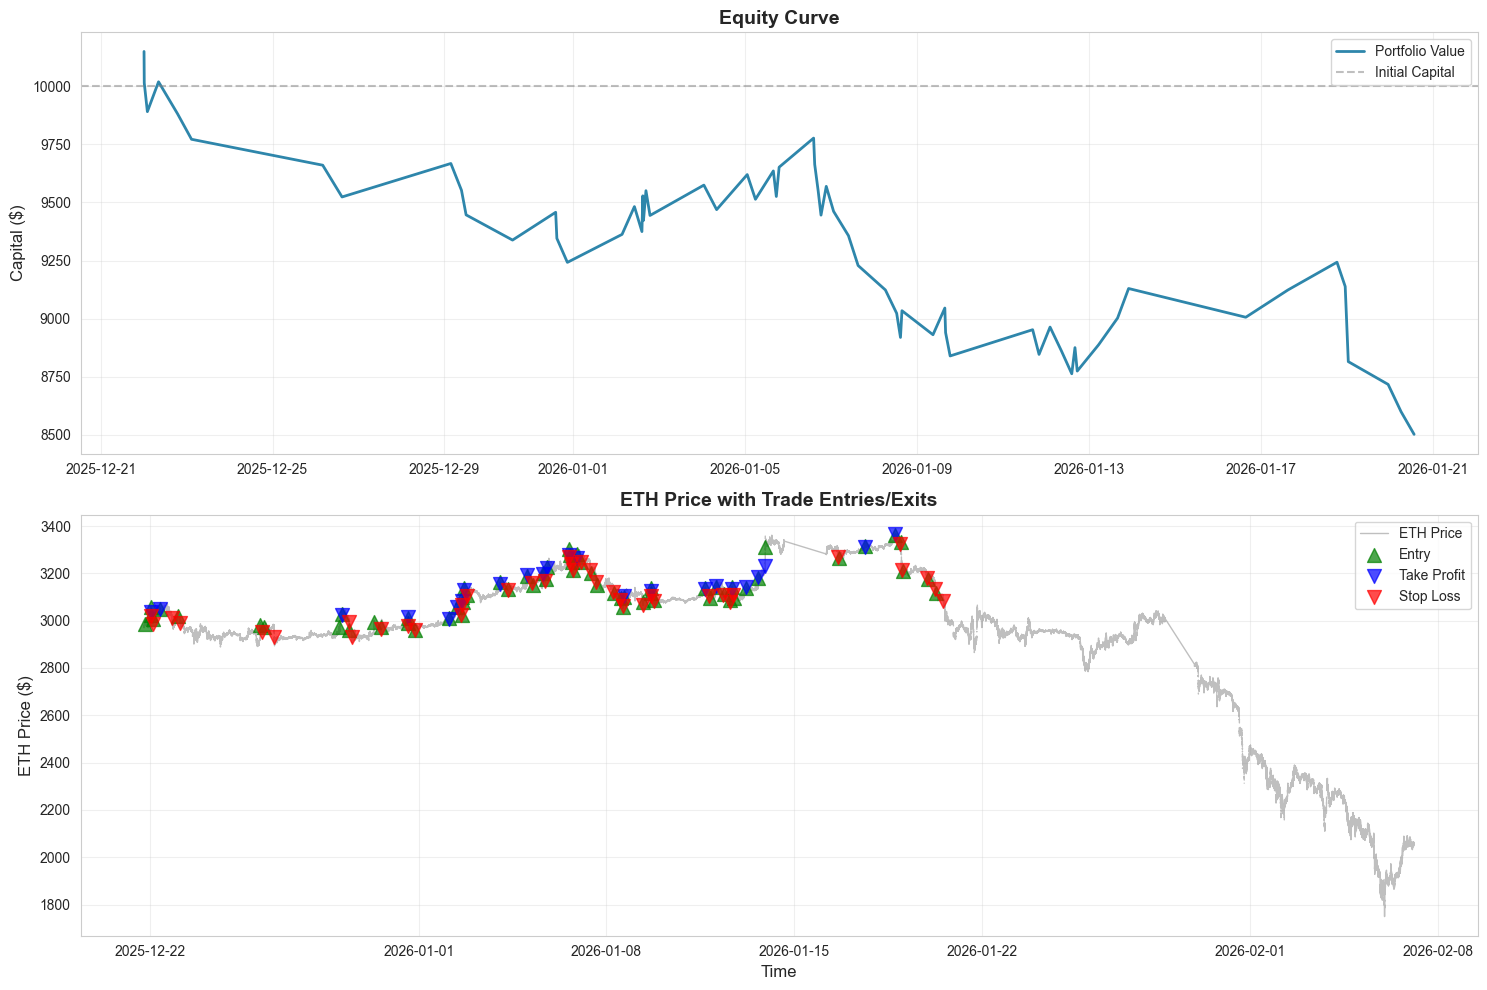

In [78]:
engine.plot_results(metrics)

---

# Trade Analysis

## 19. Examine Individual Trades

In [79]:
trades_df = metrics['trades_df']

# Display first few trades
print("📋 Sample Trades:")
trades_df.head(10)

📋 Sample Trades:


,entry_time,entry_price,exit_time,exit_price,exit_reason,pnl,return_pct,duration
0,2025-12-21 18:46:02.451663+00:00,2983.995,2025-12-22 00:14:31.601620+00:00,3035.690,TP,149.247198,1.569767,0 days 05:28:29.149957
1,2025-12-22 00:17:01.636878+00:00,3057.925,2025-12-22 00:22:01.682112+00:00,3019.805,SL,-135.524897,-1.404476,0 days 00:05:00.045234
2,2025-12-22 00:23:01.706874+00:00,3022.155,2025-12-22 02:06:29.312612+00:00,2987.795,SL,-123.291565,-1.294992,0 days 01:43:27.605738
3,2025-12-22 02:37:04.484814+00:00,3005.340,2025-12-22 08:21:06.135315+00:00,3051.255,TP,128.400579,1.365466,0 days 05:44:01.650501
4,2025-12-22 08:32:01.259218+00:00,3050.555,2025-12-22 18:58:26.590846+00:00,3011.245,SL,-137.779742,-1.446430,0 days 10:26:25.331628
5,2025-12-23 00:32:03.656923+00:00,3020.205,2025-12-23 02:45:57.002235+00:00,2989.795,SL,-109.459898,-1.165148,0 days 02:13:53.345312
6,2025-12-26 02:27:00.580067+00:00,2983.685,2025-12-26 04:02:30.689097+00:00,2952.595,SL,-111.504429,-1.200206,0 days 01:35:30.109030
7,2025-12-26 06:00:01.558554+00:00,2971.495,2025-12-26 14:49:52.117048+00:00,2931.985,SL,-136.607305,-1.487380,0 days 08:49:50.558494
8,2025-12-29 00:36:01.229970+00:00,2973.625,2025-12-29 03:35:36.766833+00:00,3025.750,TP,143.988659,1.590236,0 days 02:59:35.536863
9,2025-12-29 03:36:01.770908+00:00,3028.205,2025-12-29 09:32:12.668257+00:00,2995.015,SL,-115.274355,-1.254149,0 days 05:56:10.897349


## 20. Trade Distribution Analysis


📊 Exit Reason Distribution:
exit_reason
SL    39
TP    24
Name: count, dtype: int64


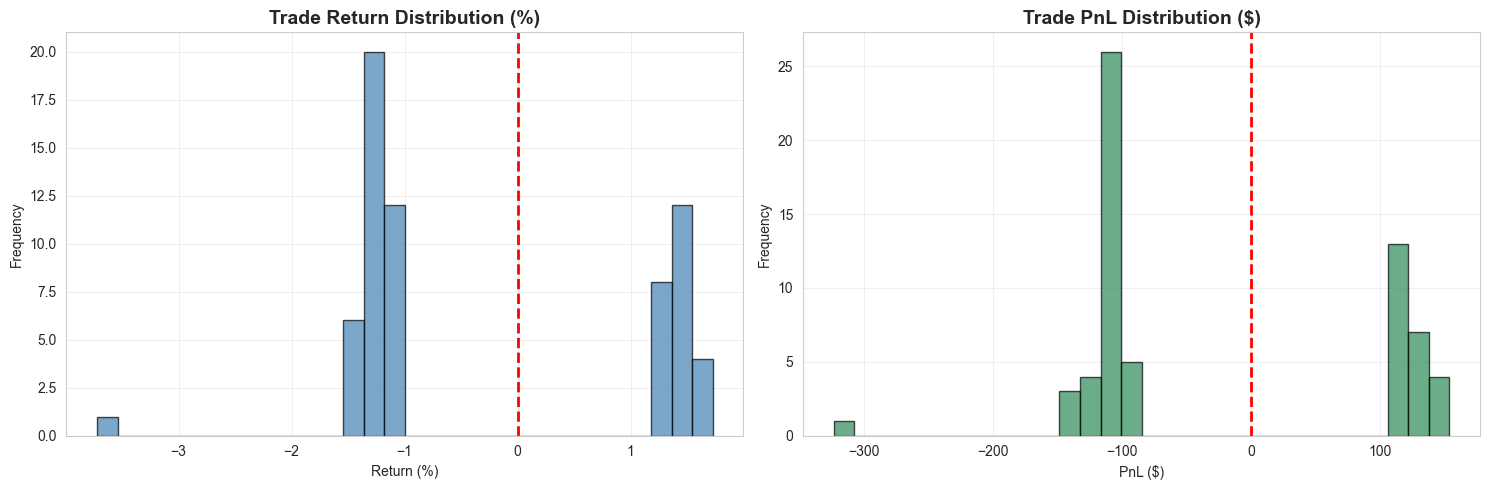

In [80]:
# Trade distribution by exit reason
print("\n📊 Exit Reason Distribution:")
print(trades_df['exit_reason'].value_counts())

# PnL distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(trades_df['return_pct'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Trade Return Distribution (%)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].hist(trades_df['pnl'], bins=30, color='seagreen', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Trade PnL Distribution ($)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PnL ($)')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()